In [96]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import wandb as wb

In [97]:
wb.login()

wandb: Currently logged in as: glasshan914 (glasshan9140) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [98]:
wb.init(project='OBP')

In [57]:
folder_list=glob.glob('E:/glass_git/AI-portfolio/order_batch_picking/data/Orderlinelist/*.txt')
dist_matrix=pd.read_pickle('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/dist_matrix.pkl')
dist_matrix=dist_matrix.to_numpy()

datasets=[]
for file in folder_list:
    df=pd.read_csv(file,sep='\t',header=None)
    cols=['order_num','index','rack','bay','tier','slot']
    df.columns=cols
    datasets.append(df)
print(f'total files: {len(datasets)}')

total files: 959


In [ ]:
#여러개 파일 중에 N번째 파일 선택
f=np.random.random_integers(1,len(datasets),1).item() #몇번째 파일을 선택할 것인지
dataset=datasets[f]

In [ ]:
def get_sample(dataset)->pd.DataFrame:
    total_order_num=len(dataset.order_num.unique())
    #파일 중 일부 order만 샘플링 후 수행
    sample_order_num=np.random.random_integers(1,total_order_num,1) #N: 몇개의 order를 뽑을 것인지
    sample_order=np.random.choice(total_order_num,size=sample_order_num,replace=False) #선택된 order_id
    sample1=dataset[dataset['order_num'].isin(sample_order)] 
    print(f'{f}번째 파일, 주문 수: {sample_order_num}')
    print(f'주문 id: {sample_order}')
    return sample1, f, sample_order_num, sample_order

In [ ]:
sample,f,sample_order_num,sample_order=get_sample(datasets)


In [ ]:
from mealpy.swarm_based import PSO
from mealpy.utils.space import CategoricalVar
from mealpy import ABC, HHO
import numpy as np
import re, logging



class WandbHandler(logging.Handler):

    def __init__(self):
        self.PAT = re.compile(r"Epoch:\s*(\d+),\s*Current best:\s*([-\d\.eE]+),\s*Global best:\s*([-\d\.eE]+),\s*Runtime:\s*([-\d\.eE]+)")
    
    def emit(self, record):
        msg = record.getMessage()
        m = self.PAT.search(msg)
        if m:
            epoch = int(m.group(1))
            cur_best = float(m.group(2))
            glob_best = float(m.group(3))
            wb.log({"epoch": epoch, "current_best": cur_best, "global_best": glob_best})

class OBP:
    def __init__(self,DIST_MATRIX,SAMPLE, K,ALPHA,DEPOT=0):
        '''  
        K : job 개수 (cluster)
        ALPHA : fitness 계산식 가중치
        DEPOT : 이동거리 계산시 원점 지정, 0번째 slot에서 출발 후 0번째 slot으로 도착하는 거리 계산
        DIST_MATRIX : 거리 행렬
        SAMPLE : 주문 번호, 상품 slot 번호 정보가 있는 주문 데이터
        '''
        #=========dataset===============
        self.dist_matrix=DIST_MATRIX
        self.sample=SAMPLE

        #=========hyper paramer==========
        self.k = K 
        self.n = len(self.sample.order_num.unique())
        self.a = ALPHA
        self.depot = DEPOT

        #========logging=================
        logger = logging.getLogger()   # 필요시 logging.getLogger("mealpy")
        logger.setLevel(logging.INFO)
        logger.addHandler(WandbHandler())

       
    def _get_dist(self, a, b):
        ''' 두 slot의 거리 계산 '''
        return float(self.dist_matrix[a, b])
    
    def _time_consumption(self,job_dist):
        ''' 시간=거리/속력, 성인 평균 걸음 속도= 80m/m (미터,분) '''
        max_distance=job_dist.max()
        return max_distance*80

    def _cal_dist(self,batch_order)->float:
        ''' batch 별로 거리 계산 '''
        items = sorted(batch_order['slot'].tolist())
        n = len(items)
        if n == 0:
            return 0.0
        if n == 1:
            # depot -> item -> depot
            return self._get_dist(self.depot, items[0]) + self._get_dist(items[0], self.depot)

        total = 0.0
        # 인접 이동
        for i in range(n - 1):
            total += self._get_dist(items[i], items[i+1])
        # depot 왕복
        total += self._get_dist(self.depot, items[0])
        total += self._get_dist(items[-1], self.depot)
        return total

    def order_distance(self,job)->np.array:
        '''job 별 거리 값 array 반환 [dist1,dist2,dist3,dist4]'''
        # job: 길이 N 의 정수(클러스터 ID) 배열
        orders = self.sample.order_num.unique()
        groups = {c: orders[job == c] for c in np.unique(job)}  # {c1: [order ids], c2: [order ids]}
        batch_dist = []
        for batch_id, order_num in groups.items():
            batch_order = self.sample[self.sample['order_num'].isin(order_num)]
            total_distance = self._cal_dist(batch_order)
            batch_dist.append(total_distance)
        return np.array(batch_dist, dtype=float)

    
    def fitness(self,solution):
        ''' 최종 목적 함수 계산  '''
        sol = np.asarray(solution)


        #sloution이 카테고리가 아니라 numeric float로 생성될 경우-> int로 변경
        if np.issubdtype(sol.dtype, np.floating):
            job = np.rint(sol).astype(int) % self.k
        else:
            job = sol.astype(int)

        job_dist = self.order_distance(job)
        if job_dist.size == 0:
            return 0.0
        time_cost=self._time_consumption(job_dist)

        obj = self.a *time_cost + (1-self.a)*job_dist.var()
        return float(obj)
    

    def model(self,params):
        ''' params: {epoch: , popsize: , nlimits: , seed: }  '''
        return ABC.OriginalABC(epoch=params.get('epoch'), pop_size=params.get('popsize'), n_limits = params.get('nlimits'), seed=params.get('seed'))

    def run(self,model):
        bounds = [CategoricalVar(valid_sets=tuple(range(self.k))) for _ in range(self.n)] # [1],[1],[2],[2],[0],[3],... : order id

        problem = {
            "obj_func": self.fitness,   # ✅ 키 이름 수정
            "bounds": bounds,
            "minmax": "min",
        }
        # model =HHO.OriginalHHO(epoch=1000, pop_size=1000)
        # model = self.model(params)
        best = model.solve(problem)

        print("최적 해:", best.solution)
        print("최적 값:", best.target)
        return best
    
    def result(self,best,wh_location,save_path):
        sample_orders=self.sample.order_num.unique()
        result=pd.DataFrame({'order_num':sample_orders, 'job':best.solution.tolist()})
        sample2=self.sample.copy()
        final=sample2.merge(result,how='left',on='order_num')[['slot','job']]
        final_location=wh_location.merge(final,how='left',on='slot')
        final_location.fillna('-1',inplace=True)
        plt.figure(figsize=(20,10))
        sns.scatterplot(data=final_location,x='x',y='y',hue='job')
        plt.title(f'fitness: {best.target}')
        plt.savefig(save_path)
        plt.show()
        plt.close()
        return print(f'Save plot {save_path} done!')


In [ ]:
wh_location=pd.read_csv('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/warehouse_coordinates.csv')
dist_matrix=pd.read_pickle('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/dist_matrix.pkl')
dist_matrix=dist_matrix.to_numpy()

K = 3 
ALPHA = 0.8
model_params={'epoch':1000 , 'popsize': 1000, 'nlimits': 5 , 'seed': 42} 

wb.init(project="OBP", name="abc-001", 
        config=dict(
            algo="ABC", 
            epoch=model_params.get('epoch'), 
            pop_size=model_params.get('popsize'), 
            n_limits=model_params.get('nlimits'), 
            seed=model_params.get('seed'),
            data_file_num=f,
            the_number_of_orders=sample_order_num,
            orders_id=sample_order,
            job=K,
            alpha=ALPHA,
            depot=0
))

obp=OBP(dist_matrix,sample, K,ALPHA)
model=obp.model(model_params)
obp.run(model)

2025/09/01 03:09:18 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: OriginalABC(epoch=1000, pop_size=1000, n_limits=5)
2025/09/01 03:09:34 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 1, Current best: 19218080.0, Global best: 19218080.0, Runtime: 7.74716 seconds
2025/09/01 03:09:42 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 2, Current best: 19218080.0, Global best: 19218080.0, Runtime: 8.80350 seconds
2025/09/01 03:09:55 PM, INFO, mealpy.swarm_based.ABC.OriginalABC: >>>Problem: P, Epoch: 3, Current best: 19449617.777777776, Global best: 19218080.0, Runtime: 12.50985 seconds


KeyboardInterrupt: 

In [ ]:
wh_location=pd.read_csv('E:/glass_git/AI-portfolio/order_batch_picking/data/Distance matrix/warehouse_coordinates.csv')

sample_orders=sample.order_num.unique()
result=pd.DataFrame({'order_num':sample_orders, 'job':best.solution.tolist()})
sample2=sample.copy()
final=sample2.merge(result,how='left',on='order_num')[['slot','job']]
final_location=wh_location.merge(final,how='left',on='slot')
final_location.fillna('-1',inplace=True)


,slot,job
0,2295,2.0
1,251,2.0
2,2791,2.0
3,1378,2.0
4,1924,2.0
...,...,...
1649,264,2.0
1650,1813,2.0
1651,1926,2.0
1652,972,2.0


In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=final_location,x='x',y='y',hue='job')
plt.title(f'fitness: {best.target}')
plt.savefig()
plt.show()
plt.close()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_24208\1632669353.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_location.fillna('-1',inplace=True)


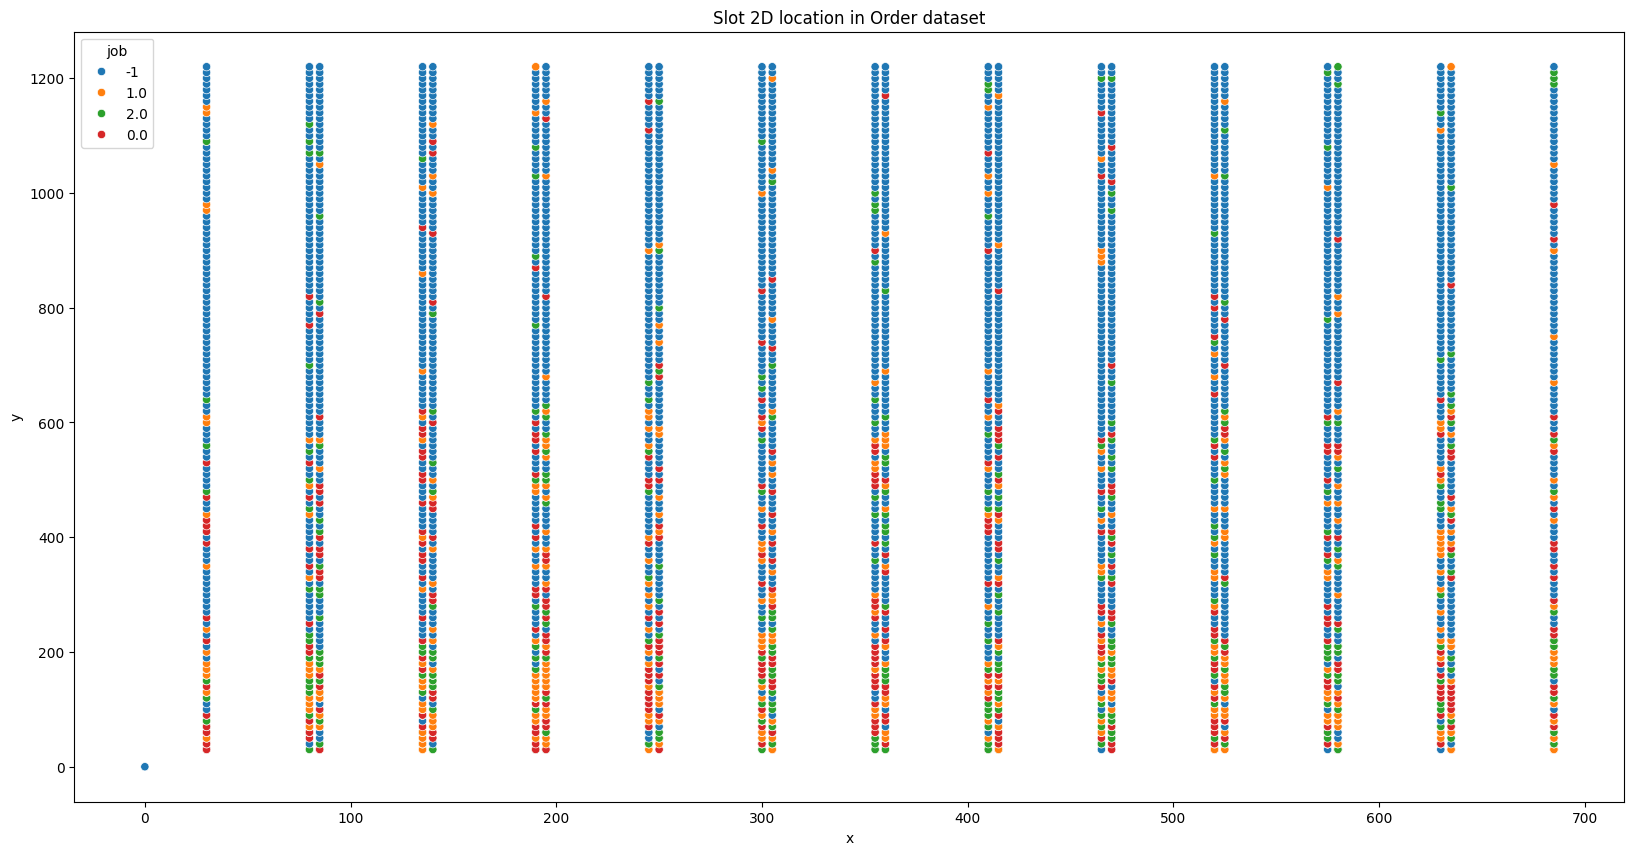